In [2]:
library(knitr)
library(sqldf)
library(ggplot2)
library(mongolite)
library(ggplot2)
library(gridExtra)
library(dplyr)
library(tidyr)
library(jsonlite)
library(lubridate)
library(gridExtra)
library(GGally)
library(scales)
library(memisc)
 library(sp)
library(rgeos)
library(rgdal)
library(maptools)
library(RColorBrewer)
library(maps)
library(grid)
library(cluster)
#library(StatMatch)
library(fastcluster)
library(factoextra)
library(stringr)
library(googleVis)
library(RMySQL)
library(data.table)
library(dbplyr)
library(DBI)
library(httr)
library(slam)
library(lda)
library(topicmodels)
library(stringi)
library(tm)
library(ldatuning)
library(tidytext)
library(RTextTools)
library(lexicon)
library(syuzhet)
library(coreNLP)
library(sentimentr)
#library(clue)
library(openssl)

Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite

Attaching package: 'dplyr'

The following object is masked from 'package:gridExtra':

    combine

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date


Attaching package: 'GGally'

The following object is masked from 'package:dplyr':

    nasa

Loading required package: lattice
Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select


Attaching package: 'memisc'

The following object is masked from 'package:scales':

    percent

The following object is masked from 'package:lubridate':

    is.interval

The following objects are masked from 'package:dplyr':

    collect, recode, rename, syms

The following objec

In [3]:
plot.format <- theme(axis.text = element_text(size = 14), legend.text = element_text(size = 14), legend.title = element_text(size = 14), axis.title = element_text(size = 18), plot.title = element_text(size = 18))

In [17]:
doc.udp.en.lem <- fread(file="../Preprocessing/Files/Lexicon/docs_udp_en_lem.csv", sep =",", header = TRUE, 
              stringsAsFactors=FALSE,
             showProgress=getOption("datatable.showProgress", interactive()), data.table=FALSE)

In [6]:
str(doc.udp.en.lem)

'data.frame':	7607581 obs. of  15 variables:
 $ doc_id       : chr  "doc1" "doc1" "doc1" "doc1" ...
 $ paragraph_id : int  1 1 1 1 1 1 1 1 1 1 ...
 $ sentence_id  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ sentence     : chr  "black teenage boys not men children stop referring year old man killing children" "black teenage boys not men children stop referring year old man killing children" "black teenage boys not men children stop referring year old man killing children" "black teenage boys not men children stop referring year old man killing children" ...
 $ token_id     : int  1 2 3 4 5 6 7 8 9 10 ...
 $ token        : chr  "black" "teenage" "boys" "not" ...
 $ lemma        : chr  "black" "teenage" "boy" "not" ...
 $ upos         : chr  "ADJ" "NOUN" "NOUN" "PART" ...
 $ xpos         : chr  "JJ" "NN" "NNS" "RB" ...
 $ feats        : chr  "Degree=Pos" "Number=Sing" "Number=Plur" NA ...
 $ head_token_id: int  2 5 5 5 6 7 0 7 10 11 ...
 $ dep_rel      : chr  "amod" "compound" "compound" "advmod" .

In [19]:
doc.udp.en.lem$X <- NULL
doc.udp.en.lem$V1 <- NULL

In [ ]:
### Remove character "a" from text

In [21]:
doc.udp.en.lem$text_mod <- gsub("\\s{1}a\\s{1}", "\\s{1}", doc.udp.en.lem$text)

In [22]:
full_text_en <- fread(file="../STSS/Files/Lexicon/full_text_en2_dc.csv", sep =",", header = TRUE, 
              stringsAsFactors=FALSE,
             showProgress=getOption("datatable.showProgress", interactive()), data.table=FALSE)

In [23]:
full_text_en$X <- NULL
full_text_en$V1 <- NULL

In [24]:
full_text_en_usa <- full_text_en %>%
                                filter(!is.na(City_code)) %>%
                                as.data.frame()

In [ ]:
#### Get custom lexicon

###### Use customise nrc_emotions lexicon

In [25]:
nrc_emotions2 <- read.csv("../Sentiment/Files/Sentiment\\nrc_emotions2.csv", 
                          stringsAsFactors = FALSE)

In [18]:
head(nrc_emotions2)

term,anger,disgust,fear,sadness,anticipation,joy,surprise,trust,sentiment,avg_sentiment,count
aback,0,0,0,0,0,0,0,0,0,0,0
abacus,0,0,0,0,0,0,0,1,1,1,1
abandon,0,0,-1,-1,0,0,0,0,-2,-1,2
abandoned,-1,0,-1,-1,0,0,0,0,-3,-1,3
abandonment,-1,0,-1,-1,0,0,1,0,-2,-1,4
abate,0,0,0,0,0,0,0,0,0,0,0


In [56]:
nrc_emotions_key <- as_key(nrc_emotions2[c("term", "avg_sentiment")], 
                           comparison = lexicon::hash_valence_shifters, sentiment = TRUE)

Warning message in as_key(nrc_emotions2[c("term", "avg_sentiment")], comparison = lexicon::hash_valence_shifters, :
"One or more terms in the first column appear as terms in the comparison.
  I found the following dubious fellas:

   * acutely
   * barely
   * colossal
   * decidedly
   * enormous
   * enormously
   * extreme
   * extremely
   * greatly
   * heavily
   * high
   * huge
   * immense
   * incalculable
   * massive
   * partly
   * purpose
   * purposely
   * rarely
   * real
   * seldom
   * severely
   * significant
   * slightly
   * totally
   * true
   * vast
   * wont

These terms have been removed.
"

write.csv(nrc_emotions_key, "C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Sentiment\\nrc_emotions_key.csv")

##### Get sentiment of documents using lowercase text, stopwords included, no hashtags for sentiment analysis

In [26]:
full_text_low <- trimws(full_text_en_usa$full_text_low, "both")

In [57]:
doc.sentiment <- sentiment(full_text_low, polarity_dt = nrc_emotions_key, 
          valence_shifters_dt = lexicon::hash_valence_shifters)

Warning message:
"Each time `sentiment` is run it has to do sentence boundary disambiguation when a
raw `character` vector is passed to `text.var`. This may be costly of time and
memory.  It is highly recommended that the user first runs the raw `character`
vector through the `get_sentences` function."

write.csv(doc.sentiment, "C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Sentiment\\doc_sentiment.csv", 
         row.names = FALSE)

doc.sentiment <- read.csv("C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Sentiment\\doc_sentiment.csv", 
                         stringsAsFactors =  FALSE)

In [15]:
str(doc.sentiment)

'data.frame':	932321 obs. of  4 variables:
 $ element_id : int  1 2 3 4 5 6 7 8 9 10 ...
 $ sentence_id: int  1 1 1 1 1 1 1 1 1 1 ...
 $ word_count : int  22 13 8 5 11 11 11 17 11 17 ...
 $ sentiment  : num  -0.426 -0.277 -0.707 0 0 ...


In [63]:
max(doc.sentiment$sentiment)

[1] 2.857738

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


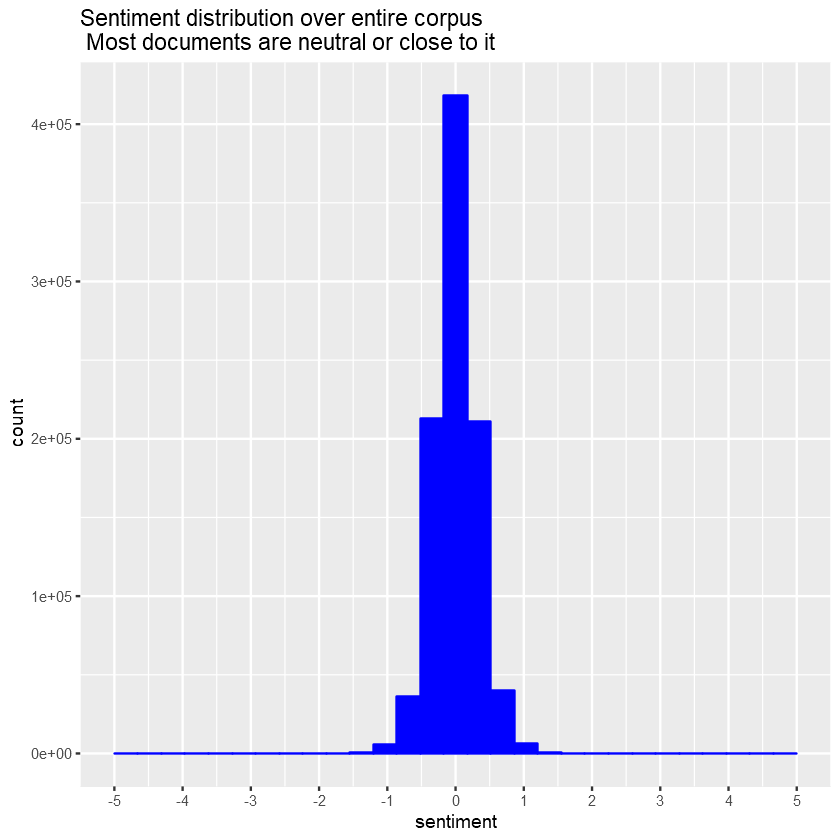

In [4]:
ggplot(aes(x = sentiment), data = doc.sentiment) +
geom_histogram(color = "blue", fill = "blue") +
scale_x_continuous(limits = c(-5, 5), breaks = seq(-5, 5, 1)) +
labs(title = "Sentiment distribution over entire corpus\n 28% of documents have positive sentiment")

In [ ]:
##### Zoom in on highly positive and negative sentiments

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 7 rows containing missing values (geom_bar)."

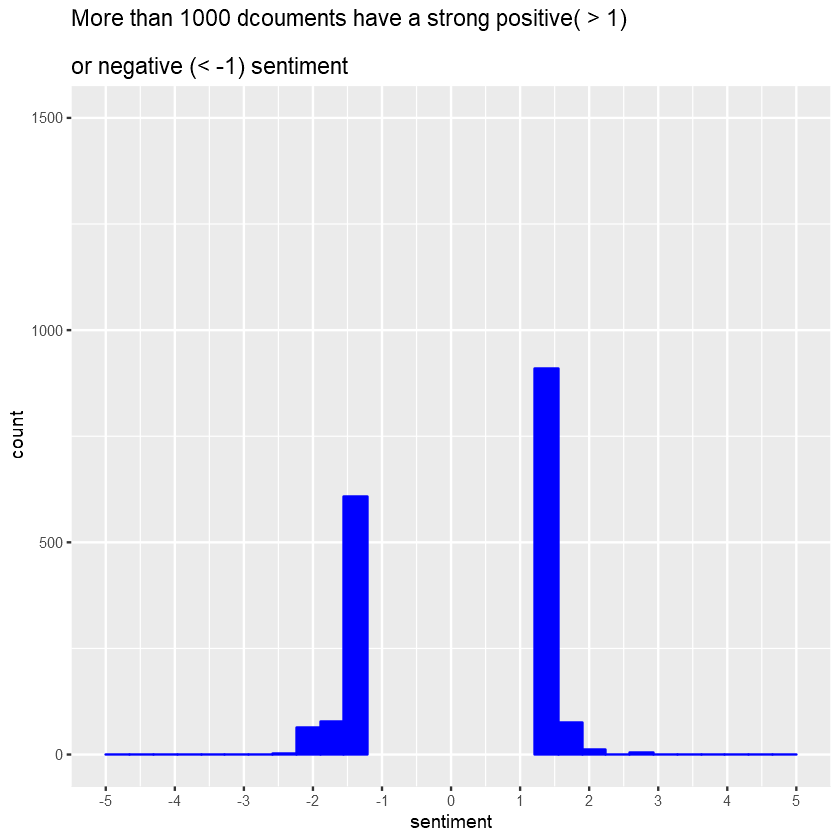

In [5]:
ggplot(aes(x = sentiment), data = doc.sentiment) +
geom_histogram(color = "blue", fill = "blue") +
scale_x_continuous(limits = c(-5, 5), breaks = seq(-5, 5, 1)) +
scale_y_continuous(limits = c(0, 1500), breaks = seq(0, 1500, 500)) +
labs(title = "More than 1000 documents have a strong positive( > 1)\n
or negative (< -1) sentiment")

In [ ]:
#### Zoom in on tweets with sentiments in the -1 to 1 range

In [102]:
round((nrow(subset(doc.sentiment, sentiment >= 0.2 | sentiment <= -0.2)))/nrow(doc.sentiment) * 100)

[1] 55

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 5117 rows containing non-finite values (stat_bin)."Warning message:
"Removed 1 rows containing missing values (geom_bar)."

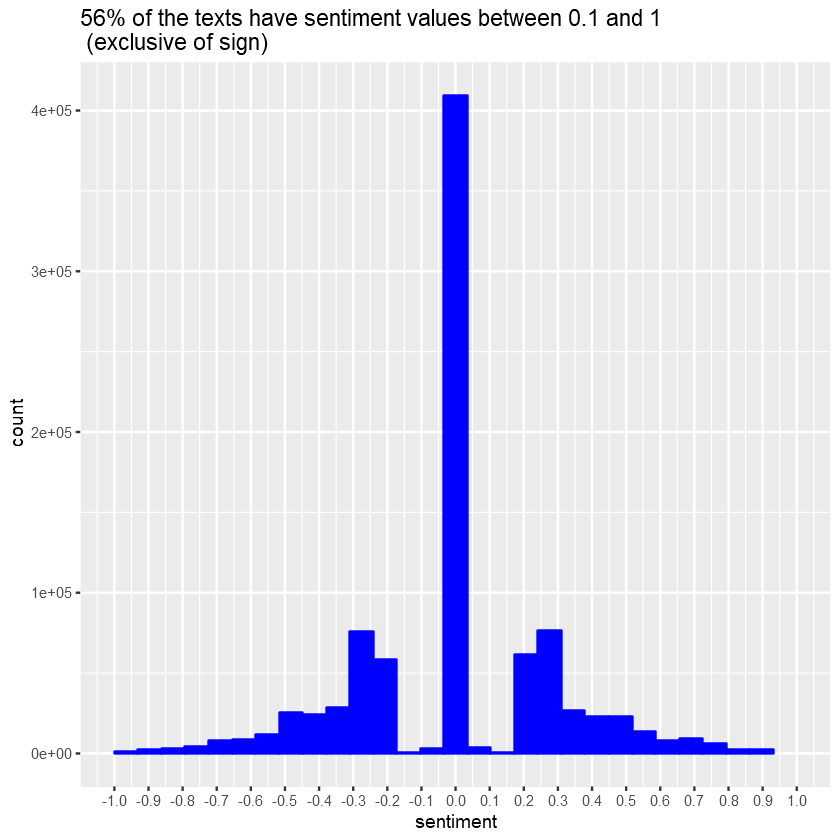

In [6]:
ggplot(aes(x = sentiment), data = doc.sentiment) +
geom_histogram(color = "blue", fill = "blue") +
scale_x_continuous(limits = c(-1, 1), breaks = seq(-1, 1, 0.1)) +
labs(title = "56% of the texts have sentiment values between 0.1 and 1\n (exclusive of sign)")

In [64]:
summary(doc.sentiment$sentiment, useNA = "ifany")

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-2.333333 -0.218218  0.000000  0.002005  0.223607  2.857738 

In [65]:
summary(doc.sentiment$word_count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1.00   10.00   15.00   14.27   18.00   86.00      11 

In [ ]:
##### Filter corpus to match documents in topic modelling - unique text_mod

##### Load features that can be used for sentiment analysis

In [28]:
sentiment.var <- full_text_en_usa %>% dplyr::select(one_of(c("textnum", "retweeted", 
                                                             "retweet", 
                                                         "favorited", "favorite_count", 
                                                             "yday",
                               "possibly_sensitive", "tweet_type", "keyword_pos_hash", 
                                 "keyword_count_hash", "full_text_low", 
                                 "full_text_low_nostop", "lon", "lat", "n", 
                                 "City_code", "City2", "Code"))) %>%
                    as.data.frame()

In [112]:
subset(nrc_emotions2, term %in% c("police", "officer", "hurt", "wild", "civilian"))

,term,anger,disgust,fear,sadness,anticipation,joy,surprise,trust,sentiment,avg_sentiment,count
2142,civilian,0,0,0,0,0,0,0,0,0,0,0
6163,hurt,-1,0,-1,-1,0,0,0,0,-3,-1,3
9466,police,0,0,-1,0,0,0,0,1,0,0,2
13992,wild,0,0,0,0,0,0,1,0,1,1,1


In [ ]:
#### Get count sentiment terms in each document - keyword count

In [22]:
token.unq <- subset(doc.udp.en.lem[c("token", "lemma")], !duplicated(token))

In [23]:
nrc.lemma <- token.unq %>% inner_join(nrc_emotions2, 
                                      by = c("token" = "term")) %>% as.data.frame()

In [41]:
head(nrc.terms)

[1] "character"

In [42]:
nrc.terms <- str_c(nrc.lemma$token, collapse = "|")
#nrc.terms <- str_c(c("black", "boy", "child", "man", "men"), collapse = "|")

In [43]:
sentiment.var$keyword_count <- str_count(sentiment.var$full_text_low_nostop, nrc.terms)

In [44]:
head(sentiment.var)# , keyword_count >= 2))

textnum,retweeted,retweet,favorited,favorite_count,possibly_sensitive,tweet_type,keyword_pos_hash,keyword_count_hash,full_text_low,full_text_low_nostop,lon,lat,n,City_code,City2,Code,keyword_count
1,FALSE,0,FALSE,107,NA,All,"c(120, 128)",1,black teenage boys are not men they are children stop referring to a year old as a man you are killing children,black teenage boys not men children stop referring year old man killing children,-82.99890,39.96136,5,COLUMBUS OH,COLUMBUS,OH,10
2,FALSE,0,FALSE,1,NA,SB,"c(87, 98, 96, 109)",2,while there please tune in todays killing of the young black male in,please tune todays killing young black male,-84.38757,33.74928,7,ATLANTA GA,ATLANTA,GA,7
4,FALSE,0,FALSE,10,NA,All,"c(50, 60, 58, 67)",2,sick and tired of police killing unarmed people,sick tired police killing unarmed people,-82.99890,39.96136,5,COLUMBUS OH,COLUMBUS,OH,6
5,FALSE,0,FALSE,2,NA,All,"c(25, 33)",1,well here we go again,well go,-84.38757,33.74928,7,ATLANTA GA,ATLANTA,GA,1
17,FALSE,1,FALSE,0,NA,RT,"c(70, 80, 78, 91)",2,please turn your radios on and tell us what happened in,please turn radios tell us happened,-90.19820,38.62717,30,ST LOUIS MO,ST LOUIS,MO,5
18,FALSE,1,FALSE,0,NA,RT,"c(70, 80, 78, 91)",2,please turn your radios on and tell us what happened in,please turn radios tell us happened,-90.19820,38.62717,30,ST LOUIS MO,ST LOUIS,MO,5


In [70]:
sentiment.var$yday <- full_text_en_usa$yday

In [71]:
sentiment.var$time <- (sentiment.var$yday - min(sentiment.var$yday) + 1)

write.csv(sentiment.var, "C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Sentiment\\sentiment_var.csv", 
         row.names = FALSE)

In [47]:
summary(sentiment.var)

    textnum        retweeted          retweet       favorited      
 Min.   :      1   Mode :logical   Min.   :0.0000   Mode :logical  
 1st Qu.:1044270   FALSE:932321    1st Qu.:1.0000   FALSE:932321   
 Median :2116844                   Median :1.0000                  
 Mean   :2112786                   Mean   :0.7654                  
 3rd Qu.:3214235                   3rd Qu.:1.0000                  
 Max.   :3884008                   Max.   :1.0000                  
                                                                   
 favorite_count          yday       possibly_sensitive  tweet_type       
 Min.   :    0.00   Min.   :221.0   Mode :logical      Length:932321     
 1st Qu.:    0.00   1st Qu.:226.0   FALSE:328450       Class :character  
 Median :    0.00   Median :228.0   TRUE :6486         Mode  :character  
 Mean   :    0.82   Mean   :227.9   NA's :597385                         
 3rd Qu.:    0.00   3rd Qu.:230.0                                        
 Max.   :141

In [ ]:
##### Combine sentiment variables with sentiment output - doc.sentiment

In [50]:
nrow(doc.sentiment)

[1] 872870

In [66]:
sentiment.var2 <- bind_cols(sentiment.var, doc.sentiment)

write.csv(sentiment.var2, "C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Sentiment\\sentiment_var2.csv", 
         row.names = FALSE)

In [ ]:
### Create binary variables for positive, negative and neutral documents. 
### Used to calculation counts

In [7]:
sentiment.var2$positive <- ifelse(sentiment.var2$sentiment >= 0.15, 1, 0)

In [8]:
sentiment.var2$negative <- ifelse(sentiment.var2$sentiment =< -0.15, 1, 0)

In [ ]:
sentiment.var2$neutral <- ifelse(sentiment.var2$sentiment < 0.15 | 
                                sentiment.var2$sentiment > -0.15,
                                      1, 0)    

In [ ]:
### Create label variable to classify documents

In [ ]:
sentiment.var2$label <- ifelse(sentiment.var2$positive == 1, '2', 
                                  ifelse(sentiment.var2$negative == 1, 
                                         '0', '1'))

In [4]:
str(sentiment.pos)

'data.frame':	264179 obs. of  22 variables:
 $ textnum             : num  43 105 176 194 207 225 256 264 296 334 ...
 $ retweeted           : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ retweet             : int  0 1 1 1 0 1 1 1 1 0 ...
 $ favorited           : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ favorite_count      : int  3 0 0 0 0 0 0 0 0 38 ...
 $ yday                : int  221 221 221 221 221 221 221 221 221 221 ...
 $ possibly_sensitive  : logi  NA NA NA NA FALSE NA ...
 $ tweet_type          : chr  "All" "RT" "RT" "RT" ...
 $ keyword_pos_hash    : chr  "c(93, 101)" "c(14, 22)" "c(126, 134)" "integer(0)" ...
 $ keyword_count_hash  : int  1 1 1 0 1 0 0 0 1 1 ...
 $ full_text_low       : chr  "police have been out of control for too long too fucking long and they are getting worse " " residents start uploading pictures and video now " " for the third time in as many weeks i have to ask please twitter friends dont photos of dead children " " there is no justificatio

write.csv(sentiment.var2, "C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Sentiment\\sentiment_pos_nrc.csv", 
         row.names = FALSE)

In [ ]:
###### 29596 tweets have no longitude and latitude location data. Remove from analysis

In [75]:
sentiment.var2 <- subset(sentiment.var2, !(is.na(lon) & is.na(lat)))

In [ ]:
##### Replace NAs in possibly_sensitive with the mode - FALSE

In [76]:
sentiment.var2$possibly_sensitive <- ifelse(is.na(sentiment.var2.ml$possibly_sensitive), FALSE, TRUE)

In [ ]:
##### Examine favorited tweets

In [77]:
table(sentiment.var2$favorited)


 FALSE 
902725 

In [ ]:
###### Replace favorited values with TRUE if favorite_count > 0

In [78]:
sentiment.var2$favorited <- ifelse(sentiment.var2$favorite_count > 0, TRUE, FALSE)

In [79]:
table(sentiment.var2$favorited)


 FALSE   TRUE 
812208  90517 

write.csv(sentiment.var2, "C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Sentiment\\sentiment_pos_nrc.csv", 
         row.names = FALSE)